In [1]:
using CSV
using DataFrames

In [2]:
include("create_model.jl")
include("structures.jl")
include("visualization_functions.jl")
include("auxiliary_functions.jl")

bottleneck_metrics (generic function with 1 method)

In [3]:
#NEW DATA:
newdata = CSV.read("data/input_data/input_data_30-10-2024_seed_42.csv", DataFrame; delim=';')

Row,Order,Job,Path,Arrival,Resource_idx,Resource_2,Resource_3,Resource_4,Resource_5,Resource_6,Resource_7,job_WC,Duration,MinDelivery,Slack,Duedate
,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Int64
1,1,1,9,1,3,0.0,5.98325,0.0,0.0,0.0,0.0,5.98325,2,6,3.0,10
2,1,2,9,1,5,0.0,0.0,0.0,3.99601,0.0,0.0,3.99601,2,6,3.0,10
3,1,3,9,1,7,0.0,0.0,0.0,0.0,0.0,0.577784,0.577784,2,6,3.0,10
4,2,4,6,1,2,8.1297,0.0,0.0,0.0,0.0,0.0,8.1297,4,7,3.05,12
5,2,5,6,1,3,0.0,4.45847,0.0,0.0,0.0,0.0,4.45847,1,7,3.05,12
6,2,6,6,1,7,0.0,0.0,0.0,0.0,0.0,0.702172,0.702172,2,7,3.05,12
7,3,7,6,1,2,1.79666,0.0,0.0,0.0,0.0,0.0,1.79666,1,5,2.05,9
8,3,8,6,1,3,0.0,5.01364,0.0,0.0,0.0,0.0,5.01364,2,5,2.05,9
9,3,9,6,1,7,0.0,0.0,0.0,0.0,0.0,1.20562,1.20562,2,5,2.05,9


In [4]:
newdata = newdata[1:103,:]

Row,Order,Job,Path,Arrival,Resource_idx,Resource_2,Resource_3,Resource_4,Resource_5,Resource_6,Resource_7,job_WC,Duration,MinDelivery,Slack,Duedate
,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Float64,Int64
1,1,1,9,1,3,0.0,5.98325,0.0,0.0,0.0,0.0,5.98325,2,6,3.0,10
2,1,2,9,1,5,0.0,0.0,0.0,3.99601,0.0,0.0,3.99601,2,6,3.0,10
3,1,3,9,1,7,0.0,0.0,0.0,0.0,0.0,0.577784,0.577784,2,6,3.0,10
4,2,4,6,1,2,8.1297,0.0,0.0,0.0,0.0,0.0,8.1297,4,7,3.05,12
5,2,5,6,1,3,0.0,4.45847,0.0,0.0,0.0,0.0,4.45847,1,7,3.05,12
6,2,6,6,1,7,0.0,0.0,0.0,0.0,0.0,0.702172,0.702172,2,7,3.05,12
7,3,7,6,1,2,1.79666,0.0,0.0,0.0,0.0,0.0,1.79666,1,5,2.05,9
8,3,8,6,1,3,0.0,5.01364,0.0,0.0,0.0,0.0,5.01364,2,5,2.05,9
9,3,9,6,1,7,0.0,0.0,0.0,0.0,0.0,1.20562,1.20562,2,5,2.05,9


In [5]:
I = length(newdata.Job)
K = maximum(newdata.Resource_idx)-1
capacity = [6, 6, 6, 8, 9, 2]
P = newdata.Duration
D = newdata.Duedate
A = newdata.Arrival
T = 130 #Number of time steps
M = 10000; 
WC = Matrix(newdata[:,6:11])
OA = newdata.Arrival;
MinDelivery = newdata.MinDelivery
N_order = maximum(newdata.Order)

29

In [6]:
workload_distribution = "free"
timing_template = "fixed"

"fixed"

In [7]:
prec_consts = all_precedence_constraints(newdata)
model = Model(HiGHS.Optimizer)

A JuMP Model
├ solver: HiGHS
├ objective_sense: FEASIBILITY_SENSE
├ num_variables: 0
├ num_constraints: 0
└ Names registered in the model: none

In [8]:
@variable(model, C[1:I] >= 0) #Completion times
@variable(model, R[1:I, 1:K, 1:T] >=0) #Resource workloads
@variable(model, tardiness[1:I] >= 0) #Tardiness of jobs
@variable(model, Max_tardiness >= 0) #Tardiness of job with largest tardiness
@variable(model, c[1:I, 1:T], Bin) #Job completion
@variable(model, X[1:I, 1:T], Bin) #1 if work i is ongoing
    
    
    
for i in 1:I
    @constraint(model, sum(c[i, t] for t in 1:T) == 1)
end
    
#equation 3
    
for i in 1:I   
    @constraint(model, sum(t*c[i,t] for t in 1:T) == C[i]) 
end
    
    #equation 5
    #TODO: TARKISTA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
for i in 1:I
    @constraint(model, C[i] - P[i] >= A[i])
end
    
    #Capacity constraint: Capacity of any machine shall not be exceeded at any time step
    #FIXME: LIIAN SUURIA KUORMIA NYT PAIKOTELLEN!!!
    #Voisiko johtua siitä, että osa duuneista jotka kuormittavat resurssia, eivät ole välttämättä työikkunan duuneissa, ja täten alla oleva summaus ei summaa 
    #kaikkia töitä?
    #TODO: luo muuttuja, johon tallennetaan jäädytettyjen töiden R-muuttujat. Ei siis välttämättä opt-malli-muuttuja.
for t in 1:T
    for k in 1:K
        @constraint(model, (capacity[k] - sum(R[i, k, t] for i in 1:I)) >= 0)
    end
end
    
    #Fixed version
for i in 1:I
    for t in 1:T
        @constraint(model, X[i,t] == sum(c[i,u] for u in (t+1):(t+P[i]) if u <= T))
    end
end
    

    #Tardiness constraint:
    #TODO: TARKISTA!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
for i in 1:I
    @constraint(model,  C[i] - D[i] <= tardiness[i])
end

    #Max tardiness:
for i in 1:I
    @constraint(model, Max_tardiness >= tardiness[i])
end

all_jobs = collect(keys(prec_consts))
for job in all_jobs
    if timing_template == "fixed" #finish time of predecessor == starting time of successor
        successor = prec_consts[job]
        @constraint(model, model[:C][job] == model[:C][successor] - P[successor]) #if job is in job window, so will its successor also be
    elseif timing_template == "free"
        successor = prec_consts[job]
        @constraint(model, model[:C][job] <= model[:C][successor] - P[successor]) #if job is in job window, so will its successor also be
    else
        print("error")
    end
end

if workload_distribution == "even"
    for i in 1:I
        for t in 1:T
            for k in 1:K
                #NOTICE: j: job index, i: index of job in vector. i has to be used accessing P_w
                #Model variables can be accessed with j.
                @constraint(model, model[:R][i,k,t] == WC[i,k]*model[:X][i,t]/P[i]) #equation 11 (even workload distribution)
            end
        end
    end
elseif workload_distribution == "free"
    for i in 1:I
        for k in 1:K
            @constraint(model, sum(model[:R][i,k,t] for t in 1:T) == WC[i,k]) #equation 9 (free workload distribution)
            for t in 1:T
                @constraint(model, model[:R][i,k,t] <= (M*model[:X][i,t]))  #equation 10
            end
        end
    end
else
    print("error")
end

@objective(model, Min,  Max_tardiness)

Max_tardiness

In [ ]:
#set_silent(model)
set_optimizer_attribute(model, "mip_rel_gap", 0.05) 
@time optimize!(model)

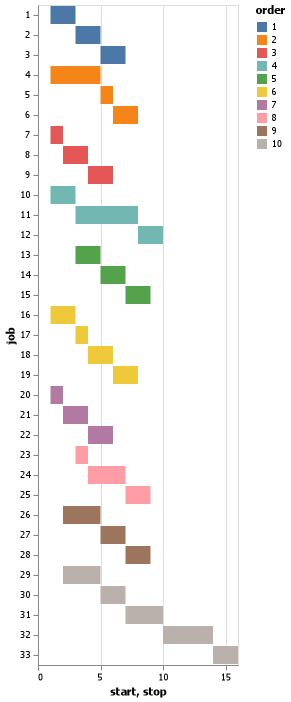

In [10]:
O = newdata.Order
create_gantt_chart(c, T, P, I, O)